In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr30k_word/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
print(len(test_captions))
test_captions.head()

5000


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,caption_id,caption,fname
0,0.014374,0.006487,-0.042115,-0.058029,0.036493,-0.012606,0.017660,-0.003536,-0.027002,0.672071,...,-0.007479,-0.054052,0.024768,0.009723,-0.004624,-0.029254,0.039362,0,Workers are busy erecting scaffolding on the s...,/data/master_thesis/Flickr30k_Dataset/23845072...
1,0.007769,-0.003761,-0.044688,-0.053584,0.013478,-0.007328,0.021183,0.002066,0.025666,0.595120,...,-0.024272,-0.073400,0.019545,0.017496,-0.037832,-0.014197,-0.044824,1,"Four men are working with scaffolding , two ha...",/data/master_thesis/Flickr30k_Dataset/23845072...
2,0.006500,0.017829,-0.014951,-0.023215,0.033409,-0.005390,0.003044,0.007378,0.003112,0.596866,...,-0.006982,-0.041270,-0.024136,-0.012247,-0.011367,-0.056075,-0.035509,2,A four man construction crew is assembling sca...,/data/master_thesis/Flickr30k_Dataset/23845072...
3,0.030906,0.020851,-0.019435,-0.021689,0.018127,-0.031066,-0.005033,0.037364,0.030092,0.649415,...,-0.004811,-0.069716,-0.011067,0.005232,-0.017120,-0.014194,-0.015815,3,Four men next to campaign signs build red scaf...,/data/master_thesis/Flickr30k_Dataset/23845072...
4,-0.013861,-0.020805,-0.050314,-0.027570,0.036581,-0.009254,0.000782,-0.014671,0.032486,0.612675,...,0.018629,-0.035312,0.013951,-0.031299,-0.035975,-0.000521,-0.025029,4,four worker are constructing a scaffold .,/data/master_thesis/Flickr30k_Dataset/23845072...


In [2]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr30k_Dataset/4767559417.jpg,0.0,0.000000,0.0,5.008735,0.0,0.0,0.000000,0.000000,0.0,1.041347,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.006299,0.0,0.000000,0.899785
/data/master_thesis/Flickr30k_Dataset/4520185597.jpg,0.0,0.000000,0.0,1.239906,0.0,0.0,1.499873,0.328968,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.543348,0.0,0.000000,0.000000
/data/master_thesis/Flickr30k_Dataset/3224375029.jpg,0.0,0.000000,0.0,0.000000,0.0,0.0,0.152723,0.000000,0.0,0.000000,...,0.000000,1.166568,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.462984,0.000000
/data/master_thesis/Flickr30k_Dataset/2315973850.jpg,0.0,0.000000,0.0,0.000000,0.0,0.0,0.918754,0.000000,0.0,1.717376,...,0.000000,0.327088,0.0,1.223651,0.0,0.000000,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr30k_Dataset/237424188.jpg,0.0,1.874337,0.0,0.809172,0.0,0.0,0.000000,0.022224,0.0,0.000000,...,0.449118,0.000000,0.0,0.000000,0.0,0.103672,0.000000,0.0,0.340089,0.916679


In [3]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

[]


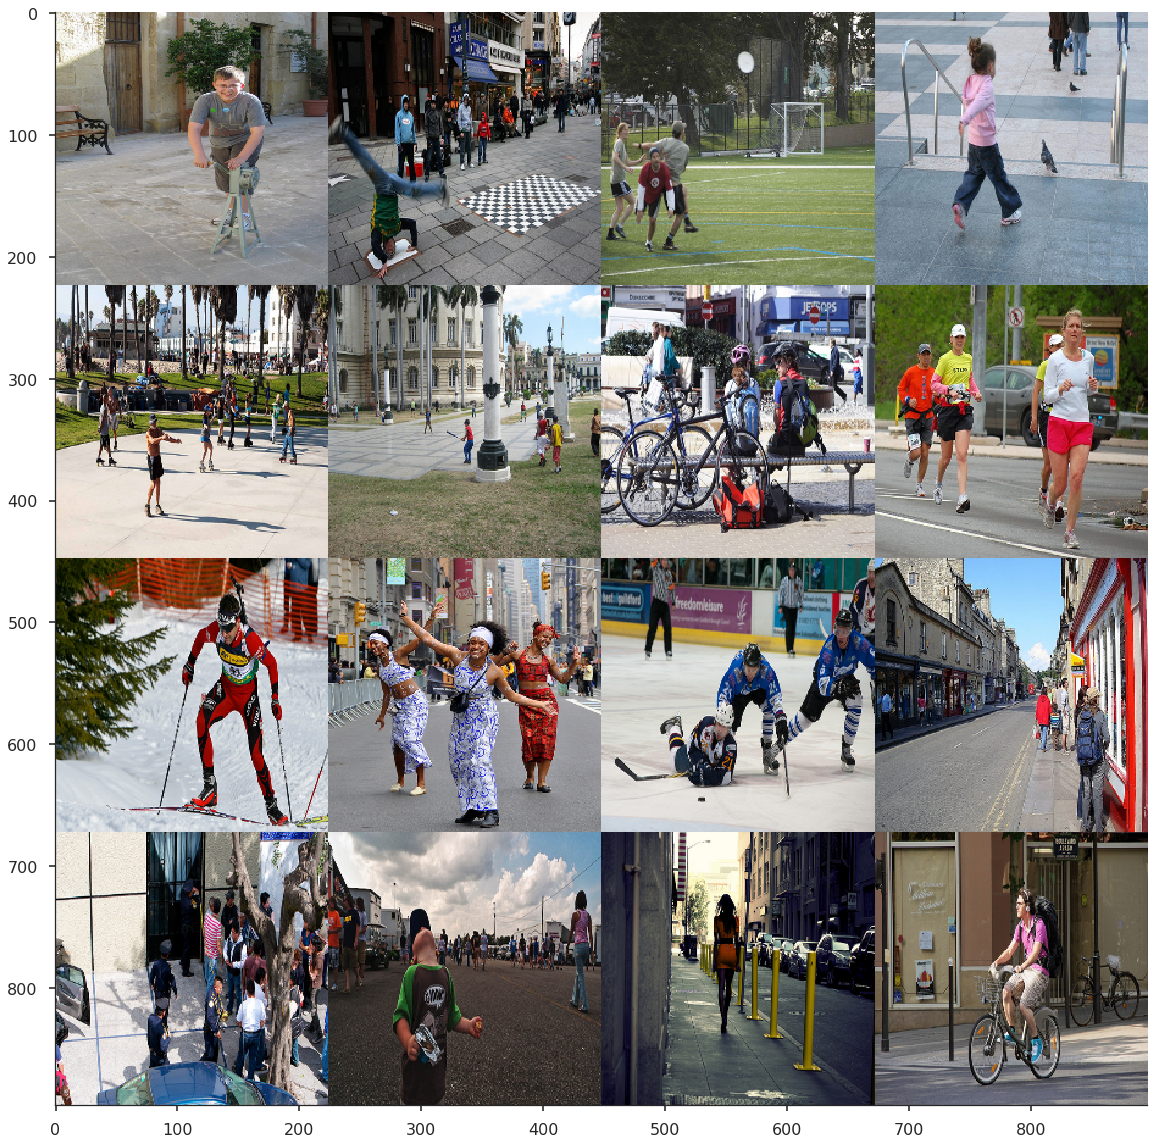

In [19]:
ax = plt.figure(figsize=(16, 16)).gca()
knn_ids = model.get_knn_images(doc='street', k=16, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
fig_array = np.ones((4, 4, 224, 224, 3))
descriptions = {}
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    fig_array[i//4, i%4] = img
    descriptions[(i, fname.name)] = test_captions.loc[(test_captions.fname == fname) &
                                                      (~test_captions.caption.str.contains('street')), 'caption']

fig_array = fig_array.transpose(0, 2, 1, 3, 4).reshape(224*4, 224*4, 3)
ax.imshow(fig_array)
sns.despine()
plt.tight_layout()
print([d for f, d in descriptions.items() if len(d) > 0])